# Tutorial on scikit-learn Gaussian Process

In [1]:
import numpy as np
from sklearn import gaussian_process
from matplotlib import pyplot as plt
import matplotlib as mt
mt.rcParams['axes.titlesize'] = 20
mt.rcParams['axes.labelsize'] = 16
mt.rcParams['xtick.labelsize'] = 12
mt.rcParams['ytick.labelsize'] = 12
mt.rcParams['legend.fontsize'] = 14

We will focus on scikit-learn gaussian process This GP example shows how to

- Design combinations of covariance functions (kernels)
- Use additive GPs whose individual components can be used for prediction
- Perform maximum a-posteriori (MAP)

## Gaussian process building blocks

Gaussian processes are a stochastic process. An example would be a collection of random variables indexed by time. To be a gaussian process and not any other kind of stochastic process, **every finite collection of these random variables must be multivariate normally distributed**.

A key fact of Gaussian processes is that defining a prior for their mean is not really important, as they can be completely defined by their second-order statistics.

Gaussian processes are mainly used for regression purposes. However, they can also be used as the prior distribution of a logistic regression, which allows them to be used for classification as well.

### KERNELS
The kernels are the core of gaussian processes, they are used to compute the _similarity_ between different points in sample space, and encode the GP prior's covariance.

There are many [builtin kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) but it is also possible to build your own through inheritance and by complying with the general kernel API.

In [2]:
# The gaussian_process.kernels module has all the builtin
# kernels and also some convinience functions
rbf = gaussian_process.kernels.RBF()
whi = gaussian_process.kernels.WhiteKernel()
exp = gaussian_process.kernels.ExpSineSquared()
dot = gaussian_process.kernels.DotProduct()
rat = gaussian_process.kernels.RationalQuadratic()
mat = gaussian_process.kernels.Matern()
kernels = [whi, rbf, mat, exp, dot, rat]

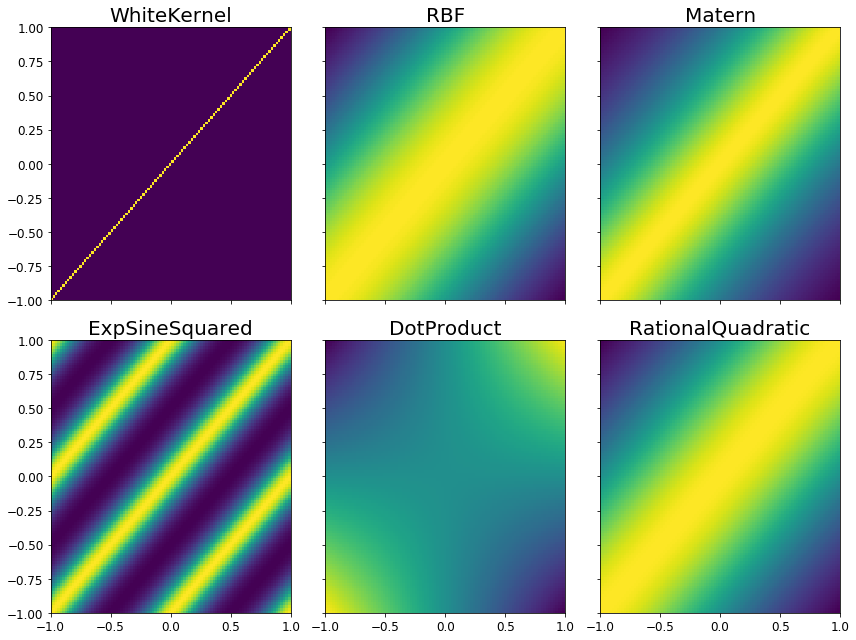

In [3]:
# We can then visualize the kernel's similarity by calling it
x = np.linspace(-1, 1, 100)
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True)
for i, kern in enumerate(kernels):
    ax = axs[i // 3, i % 3]
    vals = kern(x[:, None])
    ax.pcolor(x, x, vals.reshape((len(x), len(x))))
    ax.set_title(kern.__class__.__name__)
fig.tight_layout()

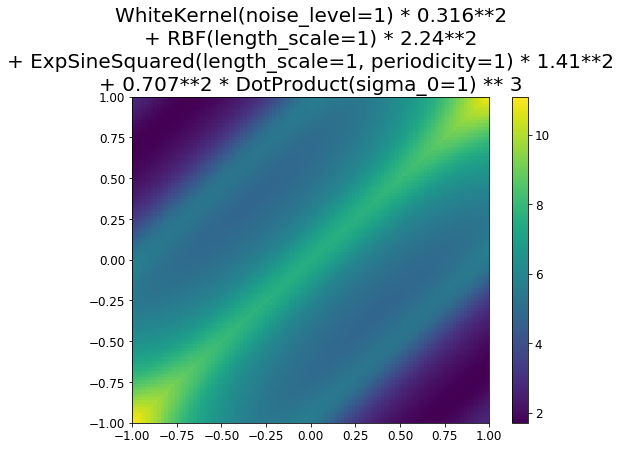

In [4]:
# Kernels allow some symbolic math operations like
# summation and exponentiation, allowing us to
# combine basic kernels into new ones
kernel = whi * 0.1 + rbf * 5 + exp * 2 + 0.5 * dot**3
vals = kernel(x[:, None])
plt.figure(figsize=(8, 6))
plt.pcolor(x, x, vals.reshape((len(x), len(x))))
plt.title(str(kernel).replace(' +', '\n+'))
plt.colorbar();

##### Exercise
1. Build a kernel that sums the constant -1 kernel, the default white kernel, an RBF with length scale equal to 2.5 and an exp sine squared kernel is periodicity 4
2. Visualize the similarity as above
---


## GP's for regressions

We will use the Mauna Loa dataset located [here](http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo). In particular we will focus on the `monthly_in_situ_co2_mlo.csv` dataset.

Since the late 1950's, the Mauna Loa observatory has been taking regular measurments of atmospheric CO$_2$.

![](http://sites.gsu.edu/geog1112/files/2014/07/MaunaLoaObservatory_small-2g29jvt.png)

Not much was known about how fossil fuel burning influences the climate in the late 1950s.  The first couple years of data collection showed that CO$_2$ levels rose and fell following summer and winter, tracking the growth and decay of vegetation in the northern hemisphere.  As multiple years passed, the steady upward trend increasingly grew into focus.  With over 70 years of collected data, the Keeling curve is one of the most important climate indicators.

## Preparing the data

In [5]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load the monthly dataset
data_monthly = pd.read_csv(os.path.join("..", "data", "monthly_in_situ_co2_mlo.csv"), header=56)
 
# - replace -99.99 with NaN
data_monthly.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = ["year", "month", "--", "--", "CO2", "seasonaly_adjusted", "fit",
        "seasonally_adjusted_fit", "CO2_filled", "seasonally_adjusted_filled"]
data_monthly.columns = cols
cols.remove("--"); cols.remove("--")
data_monthly = data_monthly[cols]

# drop rows with nan
data_monthly.dropna(inplace=True)

# fix time index
data_monthly["day"] = 15
data_monthly.index = pd.to_datetime(data_monthly[["year", "month", "day"]])
cols.remove("year")
cols.remove("month")
data_monthly = data_monthly[cols]

data_monthly.head(5)

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled
1958-03-15,315.70,314.43,316.19,314.91,315.70,314.43
1958-04-15,317.45,315.15,317.30,314.99,317.45,315.15
1958-05-15,317.51,314.72,317.85,315.07,317.51,314.72
1958-07-15,315.86,315.18,315.87,315.22,315.86,315.18
1958-08-15,314.93,316.18,314.00,315.29,314.93,316.18


In [6]:
# function to convert datetimes to numbers that are useful to algorithms
#   this will be useful later when doing prediction

def dates_to_idx(timelist):
    reference_time = pd.to_datetime('1958-03-15')
    t = (timelist - reference_time) / pd.Timedelta(1, "Y")
    return np.asarray(t)

t = dates_to_idx(data_monthly.index)

# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t = t)
data_monthly = data_monthly.assign(y_n = y_n)

[Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) book by Rasmussen & Williams uses the data up until 2003. We will use that as the training set, and then do predictions from 2003 onwards.

In [7]:
# split into training and test set
sep_idx = data_monthly.index.searchsorted(pd.to_datetime("2003-12-15"))
data_early = data_monthly.iloc[:sep_idx+1, :]
data_later = data_monthly.iloc[sep_idx:, :]

Text(0.5, 1.0, 'Raw observed CO2 levels as a function of true time')

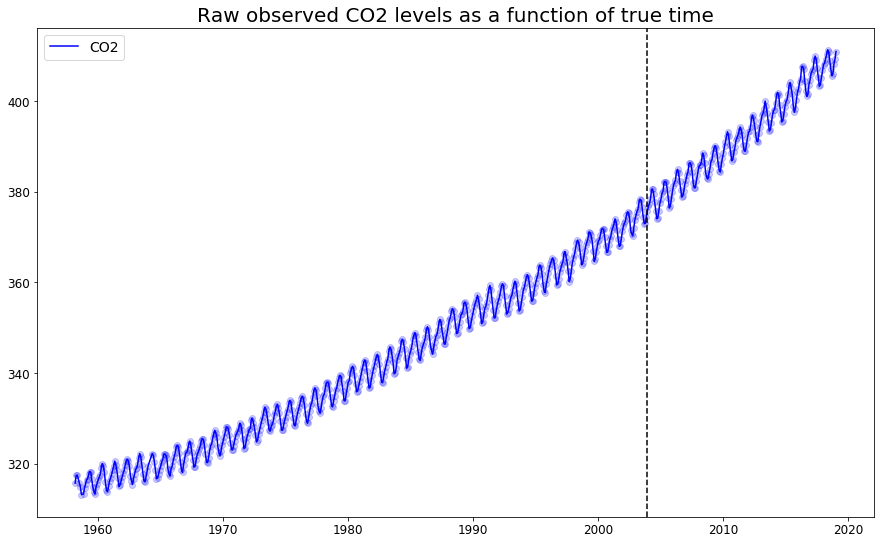

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(data_monthly.index.get_values(), data_monthly.CO2.values,
        color='b', label='CO2')
ax.plot(data_monthly.index.get_values(), data_monthly.CO2.values,
        color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline(pd.to_datetime("2003-12-15"), linestyle='--', color='k')
ax.legend()
ax.set_title('Raw observed CO2 levels as a function of true time')

Text(0.5, 1.0, 'Rescaled CO2 levels as a function of time index')

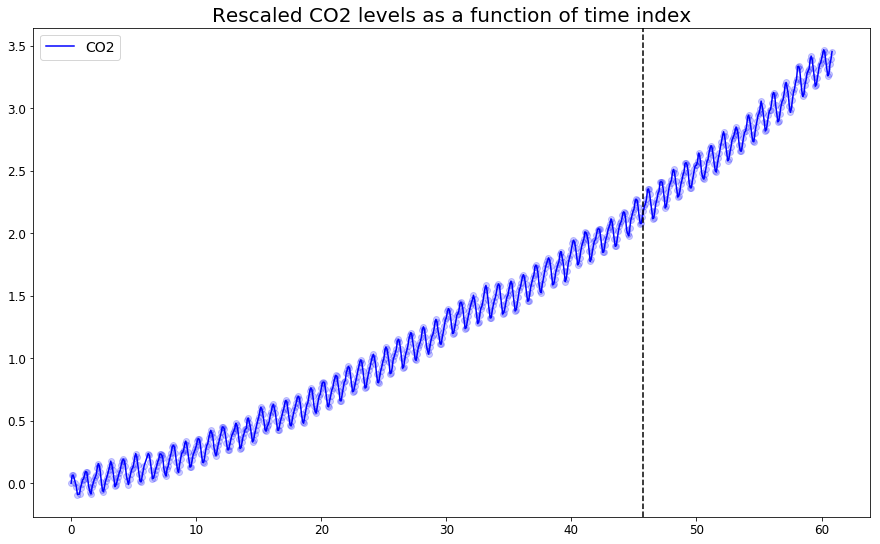

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(data_monthly.t.values, data_monthly.y_n.values,
        color='b', label='CO2')
ax.plot(data_monthly.t.values, data_monthly.y_n.values,
        color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline(dates_to_idx(pd.to_datetime("2003-12-15")), linestyle='--', color='k')
ax.legend()
ax.set_title('Rescaled CO2 levels as a function of time index')

## Fitting gaussian processes for forecasting
We will use increasingly complex kernels to explain the training data and view how the predictions work for the test set.

As an exercise, you can repeat all the following steps but using the raw CO2 levels for training and testing instead of the normalized counterpart.

In [10]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [11]:
X = data_monthly.t.values[:, None]
y = data_monthly.y_n.values
train_X = X[:len(data_early)]
train_y = y[:len(data_early)]
test_X = X[len(data_early):]
test_y = y[len(data_early):]

# To get the raw CO2 levels you should use
# y = data_monthly.CO2.values
# train_y = y[:len(data_early)]
# test_y = y[len(data_early):]

In [12]:
def plot_predictions(gp, include_observed=True):
    pred_y, pred_std = gp.predict(X, return_std=True)
    plt.figure(figsize=(10, 7))
    x = X[:, 0]
    if include_observed:
        plt.plot(x, y, 'ok', alpha=0.1)
    l, = plt.plot(x, pred_y)
    plt.fill_between(x,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color=l.get_color(), alpha=0.3)
    if np.allclose(X[:, 0], data_monthly.t.values):
        plt.axvline(dates_to_idx(pd.to_datetime("2003-12-15")), linestyle='--', color='k')
    else:
        plt.axvline(pd.to_datetime("2003-12-15"), linestyle='--', color='k')

In [13]:
k1 = 50**2 * RBF(length_scale=50.0) # Long term trend

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=k1, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp0

GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=50**2 * RBF(length_scale=50), n_restarts_optimizer=3,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [14]:
# Train the regressor
gp0.fit(train_X, train_y)

GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=50**2 * RBF(length_scale=50), n_restarts_optimizer=3,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [15]:
# We can see the kernel after training in the kernel_ attribute
gp0.kernel_

1.84**2 * RBF(length_scale=55.8)

In [16]:
# All other parameters of the GP
gp0.get_params()

{'alpha': 0.01,
 'copy_X_train': True,
 'kernel': 50**2 * RBF(length_scale=50),
 'kernel__k1': 50**2,
 'kernel__k1__constant_value': 2500,
 'kernel__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k2': RBF(length_scale=50),
 'kernel__k2__length_scale': 50.0,
 'kernel__k2__length_scale_bounds': (1e-05, 100000.0),
 'n_restarts_optimizer': 3,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [17]:
# The log marginal likelihood of the MAP can be found after training
gp0.log_marginal_likelihood_value_

575.1050313354201

In [18]:
# The fitted kernel's parameters are packed into an array
gp0.kernel_.theta

array([1.2220695 , 4.02211328])

In [19]:
# The GP also exposes the log marginal likelihood function callable
k1 = np.linspace(1e-3, 25, 50)
k2 = np.linspace(1e-3, 20, 50)
lml = np.empty((len(k1), len(k2)))
for i, k1_ in enumerate(k1):
    for j, k2_ in enumerate(k2):
        try:
            lml[i, j] = gp0.log_marginal_likelihood([k1_, k2_])
        except ValueError:
            # Numerical instabilities can cause overflows or underflows
            # we replace these errored values with NaN
            lml[i, j] = np.nan

Text(0.5, 1.0, 'Log marginal likelihood')

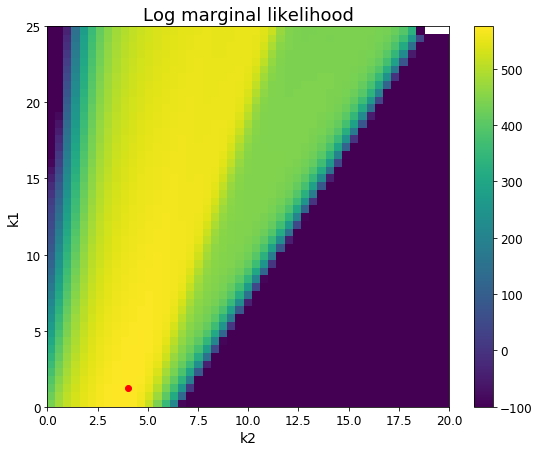

In [20]:
plt.figure(figsize=(9, 7))
plt.pcolor(k2, k1, lml,
           vmin=-100)
plt.colorbar()
plt.plot([gp0.kernel_.theta[1]], [gp0.kernel_.theta[0]],
         'or')
plt.xlabel('k2', fontsize=14)
plt.ylabel('k1', fontsize=14)
plt.title('Log marginal likelihood', fontsize=18)

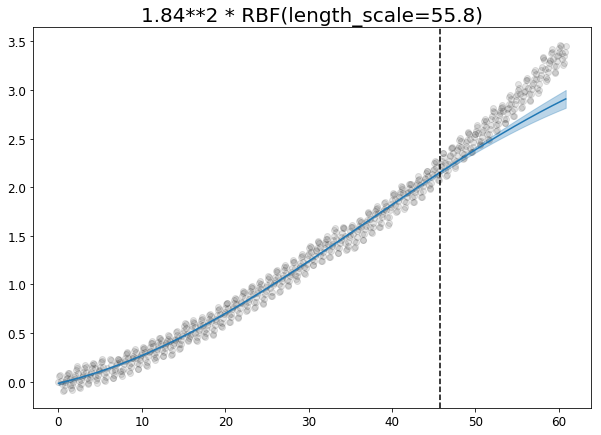

In [21]:
plot_predictions(gp0)
plt.title(str(gp0.kernel_));

0.0844**2 * RBF(length_scale=0.201) + 1.8**2 * RBF(length_scale=54) + WhiteKernel(noise_level=0.001)

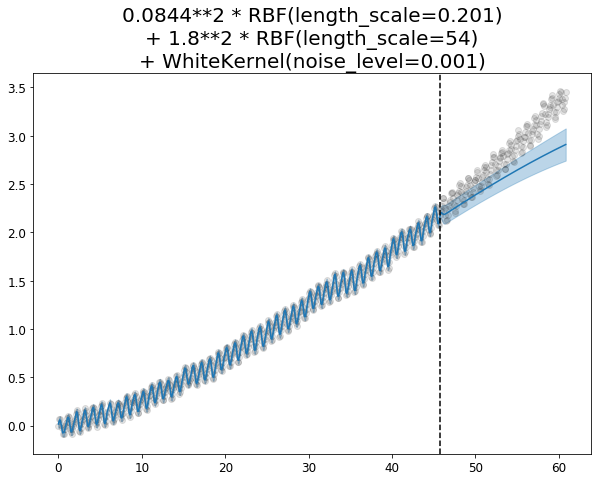

In [22]:
k1 = 50**2 * RBF(length_scale=50.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k4
gp1 = GaussianProcessRegressor(kernel=kernel, alpha=0.0,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp1.fit(train_X, train_y)
plot_predictions(gp1)
plt.title(str(gp1.kernel_).replace(' +', '\n+'))
gp1.kernel_

1.95**2 * RBF(length_scale=58.4) + 0.199**2 * RBF(length_scale=3.48e+04) * ExpSineSquared(length_scale=2.38, periodicity=1)

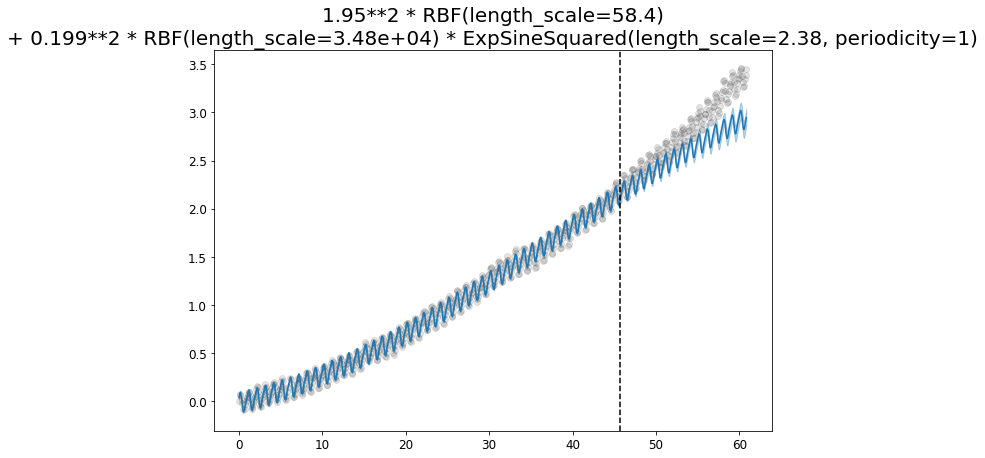

In [23]:
k1 = 50**2 * RBF(length_scale=50.0) # Long term trend
k2 = 20 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=12.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
kernel = k1 + k2
gp2 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp2.fit(train_X, train_y)
plot_predictions(gp2)
plt.title(str(gp2.kernel_).replace(' +', '\n+'))
gp2.kernel_

2.24**2 * RBF(length_scale=64.3) + 0.204**2 * RBF(length_scale=245) * ExpSineSquared(length_scale=2.39, periodicity=1) + 0.0205**2 * RBF(length_scale=1.3) + WhiteKernel(noise_level=0.001)

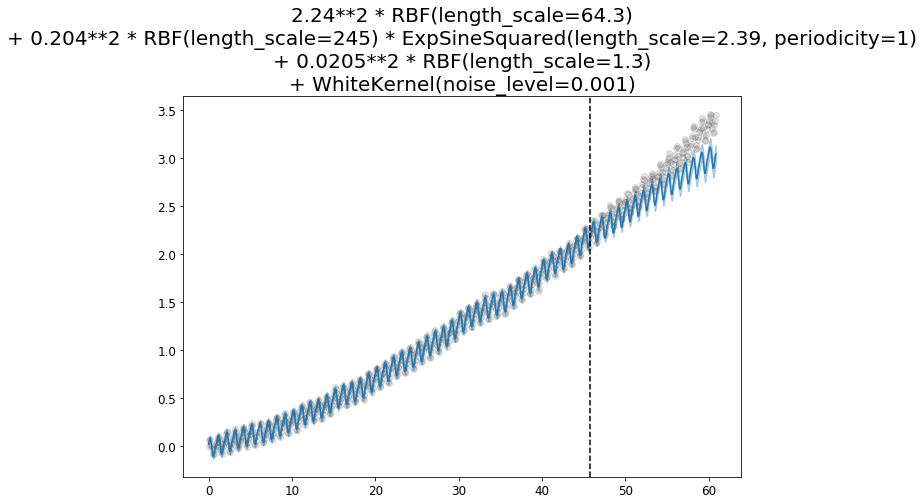

In [24]:
k1 = 50**2 * RBF(length_scale=50.0)
k2 = 20 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k2 + k4
gp3 = GaussianProcessRegressor(kernel=kernel, alpha=0.0,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp3.fit(train_X, train_y)
plot_predictions(gp3)
plt.title(str(gp3.kernel_).replace(' +', '\n+'))
gp3.kernel_

2.54**2 * RBF(length_scale=68.2) + 0.205**2 * RBF(length_scale=245) * ExpSineSquared(length_scale=2.4, periodicity=1) + 0.0215**2 * RationalQuadratic(alpha=8.01e+04, length_scale=5.74) + 0.0166**2 * RBF(length_scale=1.16) + WhiteKernel(noise_level=0.001)

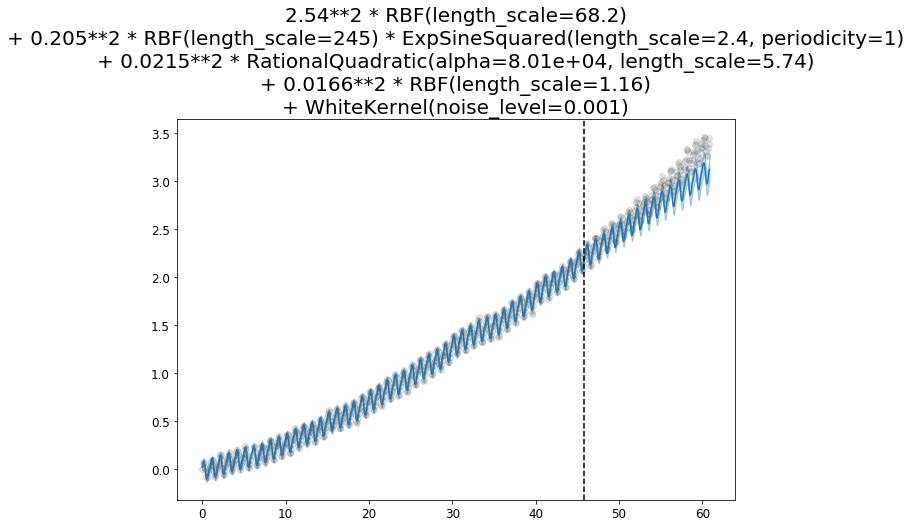

In [25]:
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k2 + k3 + k4

gp_full = GaussianProcessRegressor(kernel=kernel, alpha=0,
                                   normalize_y=True,
                                   n_restarts_optimizer=3)
gp_full.fit(train_X, train_y)
plot_predictions(gp_full)
plt.title(str(gp_full.kernel_).replace(' +', '\n+'))
gp_full.kernel_

### Take home message
* Time series forecasting is hard, mostly because you must learn a model's structure, something that is not as easily accesible as parameter optimization.
* Gaussian processes can be good models inasmuch as the kernels capture the observed dynamics well.
* When training and predicting on data disregarding the temporal structure (fit on the first part and forecast the last) then the kernel structure mostly controls how much the predictions spread out in between observations.

## Drawing samples from the GP
`GaussianProcessRegressor` and `GaussianProcessClassifier` don't only expose the common `Estimator` methods (`fit`, `predict`, `score`), they also provide the `sample_y` method, which allows us to draw samples from the stochastic process itself. Furthermore, both GP classes can do predictions in the absence of training data just by relying on their prior.

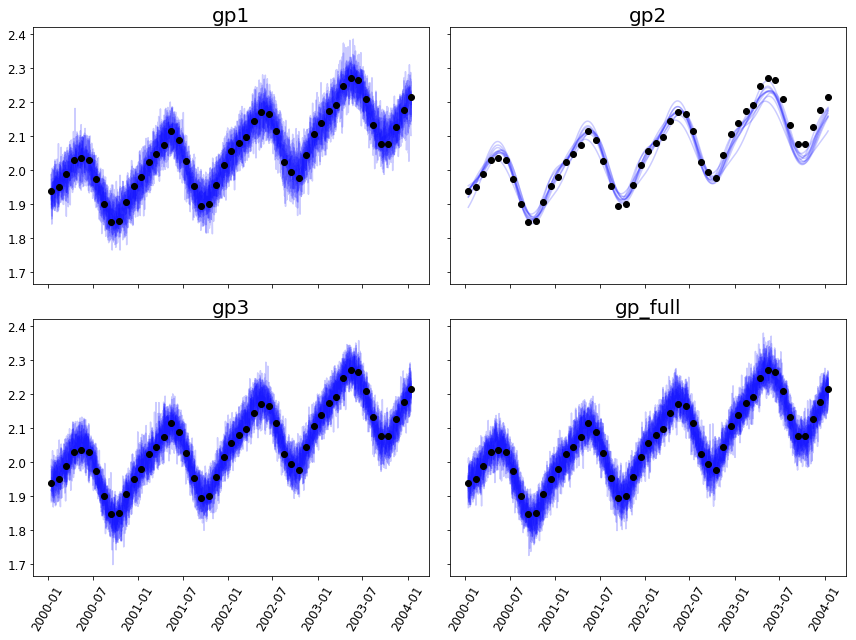

In [26]:
start = pd.to_datetime('2000-01-15')
end = pd.to_datetime('2004-01-15')
sample_range = pd.date_range(start=start,
                             end=end,
                             freq='D')
sample_x = dates_to_idx(sample_range)
data_in_range = data_monthly[start:end]
x_in_range = data_in_range.t.values
y_in_range = data_in_range.y_n.values

gps = [gp1, gp2, gp3, gp_full]
titles = ['gp1', 'gp2', 'gp3', 'gp_full']
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 9))
for i, (gp, title) in enumerate(zip(gps, titles)):
    ax = axs[i // 2, i % 2]
    sample_y = gp.sample_y(sample_x[:, None], n_samples=10)
    ax.plot(sample_range, sample_y, 'b', alpha=0.2)
    ax.plot(data_in_range.index.get_values(), y_in_range, 'ok')
    ax.set_title(title)
    if i // 2 == 1:
        ax.tick_params(axis='x', labelrotation=60)
fig.tight_layout()

##### Exercises
1. Try to explain why all of our predictions underestimate the CO2 emission rate in the prediction set.
2. Divide the CO2 data we fitted above into a train and test set without regard for the temporal ordering (you can use KFold cross validation too).
3. Fit a GP using increasingly complex kernels (start from a single RBF and move onto the full kernel used above).
4. Score each model and see which one gets the best score on the test set.
5. Visualize the learnt kernels with the 'auto-covariance' (what we called similarity at the begining of the notebook)
6. Draw samples from the GPs for the time range in between 2003 and 2018 and plot them, along with the mean and standard deviation of the GP prediction.
---

## Fitting Gaussian Processes for classification
Scikit-learn Gaussian process classification (GPC) uses Laplace approximation. The implementation sets up a GP and passes its continuous value through a logistic link function to get a class probability. For multi-class classification, several binary one-versus rest classifiers are fitted. The Laplace approximation is used to approximate non-gaussian posteriors with gaussians which allow fast, though approximate and potentially wrong, calculations.

In [27]:
# Generate data
train_size = 50
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 100)[:, None]
y = np.array(X[:, 0] > 2.5, dtype=int)

In [28]:
# Specify Gaussian Processes with fixed and optimized hyperparameters
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics.classification import accuracy_score, log_loss

gp_fix = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0),
                                   optimizer=None)
gp_fix.fit(X[:train_size], y[:train_size])

gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
gp_opt.fit(X[:train_size], y[:train_size])

GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
             multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

In [29]:
print("Log Marginal Likelihood (initial): %.3f"
      % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))
print("Log Marginal Likelihood (optimized): %.3f"
      % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))

print("Accuracy: %.3f (initial) %.3f (optimized)"
      % (accuracy_score(y[:train_size], gp_fix.predict(X[:train_size])),
         accuracy_score(y[:train_size], gp_opt.predict(X[:train_size]))))
print("Log-loss: %.3f (initial) %.3f (optimized)"
      % (log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1]),
         log_loss(y[:train_size], gp_opt.predict_proba(X[:train_size])[:, 1])))

Log Marginal Likelihood (initial): -17.598
Log Marginal Likelihood (optimized): -3.875
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.214 (initial) 0.319 (optimized)


Note that the lower the log-less is, the better. However, the best fitting log marginal likelihood gets a worse loss than the initial situation. **Why do you think that happens?**

One important feature of `GPC`'s is that is defines the method `predict_proba` that computes the predicted probability of each class for a given array of features.

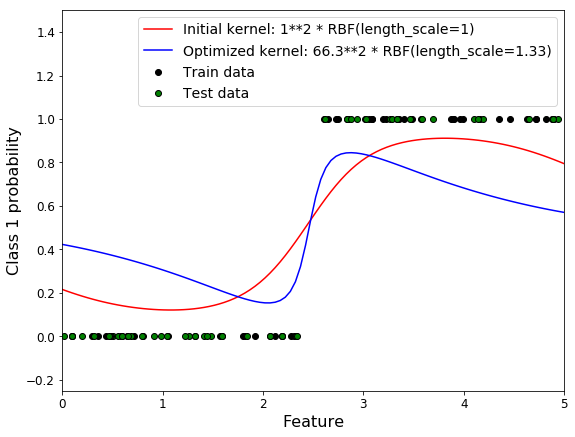

In [30]:
# Plot posteriors
plt.figure(figsize=(9, 7))
plt.scatter(X[:train_size, 0], y[:train_size], c='k', label="Train data",
            edgecolors=(0, 0, 0))
plt.scatter(X[train_size:, 0], y[train_size:], c='g', label="Test data",
            edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], 'r',
         label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(X_, gp_opt.predict_proba(X_[:, np.newaxis])[:, 1], 'b',
         label="Optimized kernel: %s" % gp_opt.kernel_)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

Text(0.5, 1.0, 'Log-marginal-likelihood')

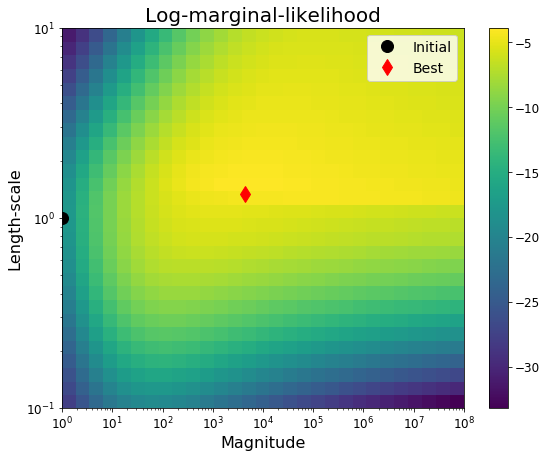

In [31]:
# Plot LML landscape
plt.figure(figsize=(9, 7))
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T
plt.plot(np.exp(gp_fix.kernel_.theta)[0], np.exp(gp_fix.kernel_.theta)[1],
         'ko', zorder=10, label='Initial', markersize=12)
plt.plot(np.exp(gp_opt.kernel_.theta)[0], np.exp(gp_opt.kernel_.theta)[1],
         'rd', zorder=10, label='Best', markersize=12)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.legend()
plt.title("Log-marginal-likelihood")

### Final remark
###### Anisotropic kernels
What we did so far always considered a single feature and a single length-scale per feature. When we have more than one feature, we can either:
1. Make the length scale the same for all features (isotropic kernel)
2. Allow the length scale to be different across features (anisotropic kernel)

Defining either kind of kernel is done very easily.

In [32]:
# import some data to play with
from sklearn import datasets
from sklearn.gaussian_process.kernels import ConstantKernel
iris = datasets.load_iris()
X = iris.data
y = np.array(iris.target, dtype=int)

isotropic_kernel = 1.0 * RBF(length_scale=1.0)
anisotropic_kernel =  1.0 * RBF(length_scale=np.ones(X.shape[1]))
print('Isotropic kernel = {}. Default parameter array = {}'.
      format(isotropic_kernel, isotropic_kernel.theta))
print('Anisotropic kernel = {}. Default parameter array = {}'.
      format(anisotropic_kernel, anisotropic_kernel.theta))
gaussian_process.kernels.DotProduct

Isotropic kernel = 1**2 * RBF(length_scale=1). Default parameter array = [0. 0.]
Anisotropic kernel = 1**2 * RBF(length_scale=[1, 1, 1, 1]). Default parameter array = [0. 0. 0. 0. 0.]


sklearn.gaussian_process.kernels.DotProduct

##### Exercises
1. Fit the iris dataset (only use the first 2 features) with GPCs that use different kernels (try Matern, RBF and DotProduct), both isotropic and anisotropic.
2. Do a cross validation to find the best performing GPC-kernel model.